In [1]:
from scipy.integrate import odeint
import numpy as np
import theano 
import theano.tensor as tt
import scipy
import matplotlib.pyplot as plt
import pymc3 as pm
%matplotlib inline
THEANO_FLAGS='optimizer=fast_compile'

In [2]:
def f(y, t, theta):
    """"This is the ODE system.
    
    The function can act on either numpy arrays or theano TensorVariables
    
    Args:
        y (vector): system state
        t (float): current time (optional)
        theta (vector): parameters of the ODEs
        
    Returns:
        dydt (list): result of the ODEs
    """
    return np.exp(-t) - theta[0]*y[0]

In [3]:
n_states = 1
n_odeparams = 1
n_ivs = 1

class ODEModel(object):

    def __init__(self, odefunc, y0, t0, times, n_states, n_ics, n_odeparams):

        self._odefunc = odefunc
        self._t0 = t0
        self._y0 = y0
        self._times = times
        self._n_states = n_states
        self._n_ics = n_ics
        self._n_odeparams = n_odeparams
        self._augmented_system = self.augment_system(odefunc)


        #ODE solution is a vector of dimension n
        #Sensitivities are a matrix of dimension nxm
        self._n = self._n_states
        self._m = self._n_odeparams + self._n_ics

        #TODO:  Add cached solver to increase speed.  Something presently wrong.
        self._cached_parameters = np.zeros(self._m)
        self._cached_sens = np.zeros((len(self._times),self._n, self._m))
        self._cached_y = np.zeros((len(self._times), self._n))

    def system(self,Y,t,p):

        """
        This is the function that wull be passed to odeint.
        Solves both ODE and sensitivities

        Args:
            Y (vector): current state and current gradient state
            t (scalar): current time
            p (vector): parameters

        Returns:
            derivatives (vector): derivatives of state and gradient
        """


        dydt, sens = self._augmented_system(Y[:self._n], 
                                            t,
                                            p,
                                            Y[self._n:],
                                            self._n,
                                            self._m
                                            )

        derivatives =  np.concatenate([dydt,sens])

        return derivatives

    def simulate(self, parameters):

        '''
        This function returns solutions and sensitivities of the ODE,
        evaluated at times and parameterized by parameters.

        Inputs:
            times(array): Times to evaluate the solution of the ODE
            parameters(array): Parameters for ODE.  Last entries should be
                               initial conditions

        Returns:
            sol(array): Solution of ODE
        '''

        #Set up the inital condition for the sensitivities
        sens_ic = np.zeros((self._n, self._m))

        #Last n columns correspond to senstivity for inital condition
        #So last n columns form identity matrix
        sens_ic[:, -self._n:] = np.eye(self._n)

        #Create an initial condition for the system
        y_ic = parameters[-self._n:]

        #Concatenate the two inital conditions to form the initial condition
        #for the augmented system (ODE + sensitivity ODe)
        y0 = np.concatenate([y_ic, sens_ic.ravel()])

        #Ensure the indicated inital time is the start of the integration
        augmented_times = np.insert(self._times, self._t0, 0)

        #Integrate
        soln = scipy.integrate.odeint(self.system,
                    y0=y0,
                    t = augmented_times,
                    args = tuple([parameters]))

        #Reshaoe the sensitivities so that there is an nxm matrix for each 
        #timestep
        y = soln[1:, :self._n]
        sens = soln[1:, self._n:].reshape((len(self._times),self._n, self._m) )

        return y,sens
    
    def augment_system(self,ode_func):
        '''Function to create augmented system.

        Take a function which specifies a set of differential equations and return
        a compiled function which allows for computation of gradients of the
        differential equation's solition with repsect to the parameters.

        Args:
            ode_func (function): Differential equation.  Returns array-like

        Returns:
            system (function): Augemted system of differential equations.

        '''

        #Shapes for the dydp dmatrix
        #TODO: Should this be int64 or other dtype?
        t_n = tt.scalar('n', dtype = 'int64')
        t_m = tt.scalar('m', dtype = 'int64')

        #Present state of the system
        t_y = tt.dvector('y')

        #Parameter(s).  Should be vector to allow for generaliztion to multiparameter
        #systems of ODEs
        t_p = tt.dvector('p')

        #Time.  Allow for non-automonous systems of ODEs to be analyzed
        t_t = tt.dscalar('t')

        #Present state of the gradients:
        #Will always be 0 unless the parameter is the inital condition
        #Entry i,j is partial of y[i] wrt to p[j]
        dydp_vec= tt.dvector('dydp')

        dydp = dydp_vec.reshape((t_n,t_m))

        #Stack the results of the ode_func
        #TODO: Does this behave the same of ODE is scalar?
        f_tensor = tt.stack(ode_func(t_y, t_t, t_p))

        #Now compute gradients
        J = tt.jacobian(f_tensor,t_y)

        Jdfdy = tt.dot(J, dydp)

        grad_f = tt.jacobian(f_tensor, t_p)

        #This is the time derivative of dydp
        ddt_dydp = (Jdfdy + grad_f).flatten()


        system = theano.function(
                inputs=[t_y, t_t, t_p, dydp_vec, t_n, t_m],
                outputs=[f_tensor, ddt_dydp],
                on_unused_input='ignore')

        return system

/Users/demetri/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: stack(*tensors) interface is deprecated, use stack(tensors, axis=0) instead.
  app.launch_new_instance()


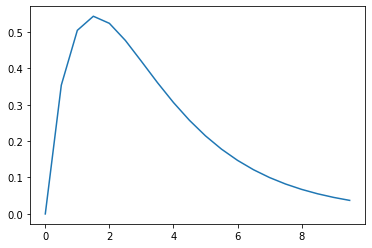

In [5]:
times = np.arange(0,10,0.5)
ode_model = ODEModel(odefunc = f, 
                   y0 = 0,
                   t0 = 0,
                    times = times,
                    n_states = 1,
                    n_ics = 1,
                    n_odeparams = 1)


sims, sens = ode_model.simulate([0.4,0])

plt.plot(times, sims)



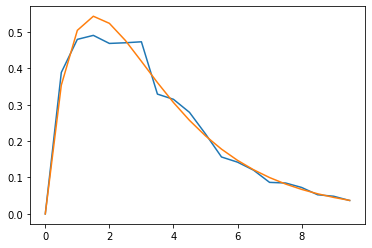

In [6]:
#Create data to learn from
Y = scipy.stats.lognorm.rvs(s = 0.1, scale = sims)
plt.plot(times,Y)
plt.plot(times,sims)


In [7]:
class solveCached(object):
    def __init__(self, times, n_params, n_outputs):
      
        self._times = times
        self._n_params = n_params
        self._n_outputs = n_outputs
        self._cachedParam = np.zeros(n_params)
        self._cachedSens = np.zeros((len(times), n_outputs, n_params))
        self._cachedState = np.zeros((len(times),n_outputs))
        
    def __call__(self, x):
        
        if np.all(x==self._cachedParam):
            state, sens = self._cachedState, self._cachedSens
            
        else:
            state, sens = ode_model.simulate(x)
        
        return state,sens
    

cached_solver=solveCached(times, n_odeparams + n_ivs, n_states)

In [16]:
def state(x):
    State, Sens = cached_solver(np.array(x,dtype=np.float64))
    cached_solver._cachedState, cached_solver._cachedSens, cached_solver._cachedParam = State, Sens, x
    return State.reshape(Y.size)

def numpy_vsp(x, g):    
    numpy_sens = cached_solver(np.array(x,dtype=np.float64))[1].reshape((n_states*len(times),len(x)))
    return numpy_sens.T.dot(g)

In [17]:
class ODEGradop(theano.Op):
    def __init__(self, numpy_vsp):
        self._numpy_vsp = numpy_vsp

    def make_node(self, x, g):
        x = theano.tensor.as_tensor_variable(x)
        g = theano.tensor.as_tensor_variable(g)
        node = theano.Apply(self, [x, g], [g.type()])
        return node

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]

        g = inputs_storage[1]
        out = output_storage[0]
        out[0] = self._numpy_vsp(x, g)       # get the numerical VSP
        

In [18]:
class ODEop(theano.Op):

    def __init__(self, state, numpy_vsp):
        self._state = state
        self._numpy_vsp = numpy_vsp

    def make_node(self, x):
        x = theano.tensor.as_tensor_variable(x)

        return theano.Apply(self, [x], [x.type()])

    def perform(self, node, inputs_storage, output_storage):
        x = inputs_storage[0]
        out = output_storage[0]
        
        out[0] = self._state(x)               # get the numerical solution of ODE states

    def grad(self, inputs, output_grads):
        x = inputs[0]
        g = output_grads[0]

        grad_op = ODEGradop(self._numpy_vsp)  # pass the VSP when asked for gradient 
        grad_op_apply = grad_op(x, g)
        
        return [grad_op_apply]

In [19]:
theano.config.exception_verbosity= 'high'
theano.config.floatX = 'float64'


# Define the data matrix


# Now instantiate the theano custom ODE op
my_ODEop = ODEop(state,numpy_vsp)

# The probabilistic model
with pm.Model() as LV_model:

    # Priors for unknown model parameters
    
    
    
    p = pm.HalfNormal('alpha',1)
    
    sigma = pm.Lognormal('sigma', mu=-1, sd=1, shape=2)

    # Forward model
    all_params = pm.math.stack([p,0],axis=0)
    ode_sol = my_ODEop(all_params)
    forward = ode_sol.reshape(Y.shape)

    # Likelihood 
    Y_obs = pm.Lognormal('Y_obs', mu=pm.math.log(forward), sd=sigma, observed=Y)
    
    trace = pm.sample(1500, tune=1000, init='adapt_diag')
trace['diverging'].sum()

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha]
Sampling 4 chains:   0%|          | 0/10000 [00:00<?, ?draws/s]


RuntimeError: Chain 0 failed.

In [ ]:
pm.gelman_rubin(trace)

In [ ]:
pm.posteriorplot.plot_posterior(trace)

In [ ]:
ppc_samples = pm.sample_posterior_predictive(trace, samples=500, model=LV_model)['Y_obs']


In [ ]:
for i in range(100):
    ppc = ppc_samples[i]
    plt.plot(ppc[:,0], alpha = 0.1, color = 'C0')
    plt.plot(ppc[:,1], alpha = 0.1, color = 'C1')